In [49]:
#read the dataset, and name the columns     
df = pd.read_csv('questions_data_clean_stopword_lemma_v3.csv', header=0)


#display the structure of the dataframe
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23289 entries, 0 to 23288
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Title                      23289 non-null  object
 1   Description                23289 non-null  object
 2   Creation Time              23289 non-null  object
 3   Link                       23289 non-null  object
 4   Clean_Text_Init            23289 non-null  object
 5   Clean_Text_Stopword        23289 non-null  object
 6   Clean_Text_Stopword_Lemma  23289 non-null  object
dtypes: object(7)
memory usage: 1.2+ MB
None


In [50]:
#sbert embedding method used with DBSCAN clustering
from sentence_transformers import SentenceTransformer
docs =df['Clean_Text_Stopword_Lemma']
#use the pretrained model available on huggingface
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
embeddings = model.encode(docs)

In [81]:
import numpy as np
from sklearn.cluster import DBSCAN

total_points = embeddings.shape[0]

#iteratively try different eps values to compare clusters
for i in range(1,5):
    #using the cosine similarity metric and 100 samples minimum in each cluster (assignment requirement)
    dbscan = DBSCAN(eps=0.1*i, min_samples=20, metric='cosine', n_jobs=-1)
    cluster_labels = dbscan.fit_predict(embeddings)
    
    num_noise = np.sum(cluster_labels == -1)
    num_assigned = total_points - num_noise
    number_of_clusters = len(set(cluster_labels))-1
    print(f"For EPS value: {round(0.1*i,1)}, They are {number_of_clusters} clusters, with {num_assigned} posts assigned")

#iteratively try different eps values to compare clusters
for i in range(1,6):
    #using the cosine similarity metric and 10 samples minimum in each cluster (assignment requirement)
    dbscan = DBSCAN(eps=0.25+0.01*i, min_samples=20, metric='cosine', n_jobs=-1)
    cluster_labels = dbscan.fit_predict(embeddings)
    
    num_noise = np.sum(cluster_labels == -1)
    num_assigned = total_points - num_noise
    number_of_clusters = len(set(cluster_labels))-1
    print(f"For EPS value: {round(0.25+0.01*i,2)}, They are {number_of_clusters} clusters, with {num_assigned} posts assigned")

For EPS value: 0.1, They are 0 clusters, with 0 posts assigned
For EPS value: 0.2, They are 2 clusters, with 84 posts assigned
For EPS value: 0.3, They are 9 clusters, with 6955 posts assigned
For EPS value: 0.4, They are 1 clusters, with 21863 posts assigned
For EPS value: 0.26, They are 14 clusters, with 2145 posts assigned
For EPS value: 0.27, They are 11 clusters, with 3000 posts assigned
For EPS value: 0.28, They are 12 clusters, with 4096 posts assigned
For EPS value: 0.29, They are 8 clusters, with 5331 posts assigned
For EPS value: 0.3, They are 9 clusters, with 6955 posts assigned


Therefore, the best value of EPS was 0.3 and they are 4 clusters with 2333 posts catagorised. 

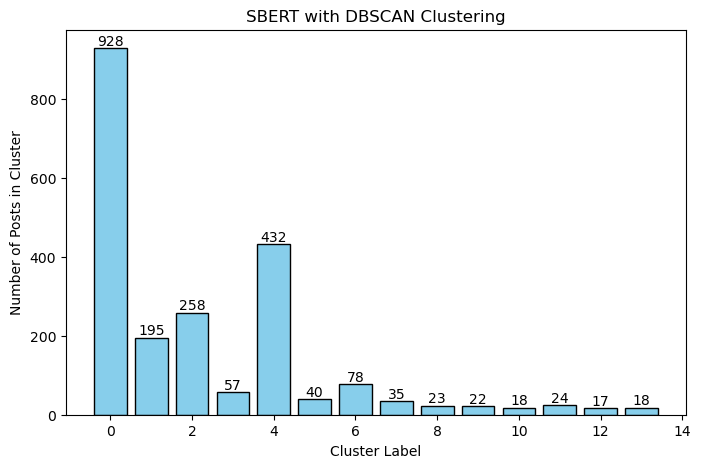

In [84]:
from sklearn.cluster import DBSCAN

#run the final sbert clustering
clustering = DBSCAN(eps=0.26, min_samples=20, metric='cosine').fit(embeddings)
cluster_labels = clustering.labels_

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter 

clusters=[]
for i in cluster_labels:
    clusters.append(i)

unique_labels, counts = np.unique(clusters, return_counts=True)

plt.figure(figsize=(8, 5)) # Adjust figure size as needed
bars = plt.bar(unique_labels[1:], counts[1:], align='center', color='skyblue', edgecolor='black')
plt.bar_label(bars)
plt.xlabel("Cluster Label")
plt.ylabel("Number of Posts in Cluster")
plt.title("SBERT with DBSCAN Clustering")
plt.show()

In [85]:
clusters = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[],11:[],12:[],13:[]}

df['ClusterID'] = [-1] * len(df)

for label in sorted(unique_labels):
    # Find indices of sentences belonging to this cluster
    indices = np.where(cluster_labels == label)[0]
    num_in_cluster = len(indices)
    example_indices = indices[:]
    for i in example_indices:
        if label!=-1:
            clusters[label].append([df.at[i,'Title'],df.at[i,'Link']])
        df.at[i, 'ClusterID'] = label


Title                           Vista speech recognition in multiple languages
Description                  <p>my primary language is spanish, but I use a...
Creation Time                                              2008-08-31 01:08:00
Link                         https://stackoverflow.com/questions/36533/vist...
Clean_Text_Init              vista speech recognition in multiple languages...
Clean_Text_Stopword          vista speech recognition multiple languages pr...
Clean_Text_Stopword_Lemma    vista speech recognition multiple language pri...
ClusterID                                                                   -1
Name: 1, dtype: object


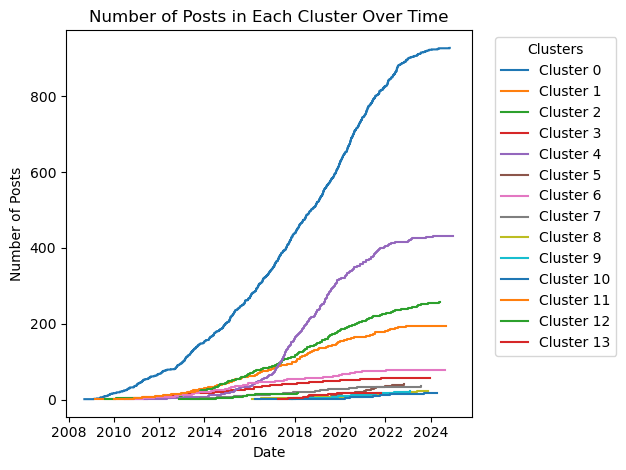

In [91]:
import seaborn as sns
#convert creation time column to pandas datetime type
df['Creation Time'] = pd.to_datetime(df['Creation Time'], format='mixed')
df=df.sort_values('Creation Time')
#for each cluster, create a time series line
for cluster_id in sorted(df['ClusterID'].unique()):
    if cluster_id!=-1:
        cluster_data = df[df['ClusterID'] == cluster_id]
        
        # Create cumulative count for this cluster
        dates = cluster_data['Creation Time']
        counts = range(1, len(cluster_data) + 1)
        plt.step(dates, counts, where='post', label=f'Cluster {cluster_id}')
plt.title('Number of Posts in Each Cluster Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend(title='Clusters', loc='upper left', bbox_to_anchor=(1.04, 1))

plt.tight_layout()
plt.show()


In [93]:
import html
import random
random.seed(123)

data = clusters

# HTML table structure with CSS for basic styling
html_output = """
<style>
  table {
    border-collapse: collapse;
    width: 100%;
    font-family: sans-serif;
  }
  th, td {
    border: 1px solid #ddd;
    padding: 8px;
    text-align: left;
    vertical-align: top; /* Align content to the top */
  }
  th {
    background-color: #f2f2f2;
  }
  tr:nth-child(even) {
    background-color: #f9f9f9;
  }
  td[rowspan] {
    font-weight: bold;
    vertical-align: top; /* Align content to the top */
    text-align: center;     /* Center the key horizontally */
  }
  a {
    color: #0066cc;
    text-decoration: none;
  }
  a:hover {
    text-decoration: underline;
  }
</style>
<table>
  <thead>
    <tr>
      <th>Cluster</th>
      <th>Title</th>
      <th>URL</th>
    </tr>
  </thead>
  <tbody>
"""
#start table
for key, items in sorted(data.items()):
    sample_size = min(10, len(items)) # Determine sample size (max 10)

    if sample_size > 0:
        sampled_items = random.sample(items, sample_size) # Get random sample
    else:
        sampled_items = [] # Handle case of empty cluster list

    rowspan_count = len(sampled_items) # Rowspan is based on sampled size

    if rowspan_count > 0: # Only proceed if there are items to display
        for i, item in enumerate(sampled_items): # Iterate over the sampled items
            title = item[0] if len(item) > 0 else "N/A"
            url = item[1] if len(item) > 1 else "#"
            escaped_title = html.escape(title)
            escaped_url = html.escape(url)

            html_output += "<tr>"
            if i == 0:
                html_output += f'<td rowspan="{rowspan_count}">{key}</td>' # Use sampled rowspan_count
            html_output += f'<td>{escaped_title}</td>'
            html_output += f'<td><a href="{escaped_url}" target="_blank">{escaped_url}</a></td>'
            html_output += "</tr>\n"

html_output += """
  </tbody>
</table>
"""

try:
    # Consider changing the filename if you want to keep the original full table
    with open('data_table_sampled.html', 'w', encoding='utf-8') as f:
        f.write(html_output)
    print("HTML table successfully saved to data_table_sampled.html")
except Exception as e:
    print(f"An error occurred while writing the file: {e}")

HTML table successfully saved to data_table_sampled.html
